In [1]:
import numpy as np

In [2]:
x = np.random.rand(10, 1, 28, 28)

x.shape

(10, 1, 28, 28)

In [4]:
print(x[0].shape)
print(x[1].shape)

(1, 28, 28)
(1, 28, 28)


In [7]:
x[0, 0]

array([[7.38684154e-01, 8.52234958e-01, 8.36790311e-01, 6.01803289e-01,
        3.27108879e-01, 4.57844706e-01, 1.09009121e-01, 7.37168562e-01,
        7.51482605e-01, 3.69753252e-01, 4.92757939e-03, 3.91149461e-01,
        9.16915936e-01, 3.35934905e-01, 4.95666567e-01, 2.53573652e-01,
        8.77190524e-01, 8.33634624e-01, 4.42758022e-01, 5.94190615e-02,
        8.78675208e-01, 1.94296467e-01, 2.61184906e-01, 8.75807544e-01,
        1.92828652e-01, 5.57420825e-01, 6.25569484e-01, 1.30804217e-01],
       [3.78643003e-01, 4.41643333e-01, 1.70600937e-01, 7.94763362e-01,
        6.67294201e-02, 7.12884259e-01, 8.17888154e-01, 6.38898681e-02,
        6.84034936e-01, 2.97084385e-01, 7.60739183e-01, 9.71925393e-01,
        2.30116546e-02, 4.33043052e-01, 5.35147074e-02, 3.28720522e-03,
        9.19390432e-01, 1.98063860e-01, 2.52911970e-01, 5.60854155e-01,
        8.61184631e-01, 7.30487508e-01, 6.80627646e-01, 6.49417831e-01,
        9.58743283e-01, 2.66555365e-01, 4.02623186e-01, 2.64338

In [8]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [10]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [11]:
class Convolution():
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

In [12]:
class Pooling():
    def __inint__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 전개(1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pae)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        # 최대값(2)
        out = np.max(col, axis=1)
        
        # 성형(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

In [13]:
from collections import OrderedDict

class SimpleConvNet():
    def __init__(self, input_dim=(1, 28, 28), 
                conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # backward path
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine3'].db
        
        return grads

train loss:2.298984276385951
=== epoch:1, train acc:0.128, test acc:0.129 ===
train loss:2.2959275241533716
train loss:2.2951948943172824
train loss:2.282572665409214
train loss:2.277508811008437
train loss:2.2610729511423724
train loss:2.2588213590677357
train loss:2.236554350151633
train loss:2.2239586336047523
train loss:2.188207591083105
train loss:2.1593262752221074
train loss:2.112291707695327
train loss:2.070265734696778
train loss:2.046517755833439
train loss:1.9339012799183277
train loss:1.9028735606549254
train loss:1.8543168850349177
train loss:1.7676385941379755
train loss:1.7074424446230487
train loss:1.598114032760549
train loss:1.5742609638112566
train loss:1.4360409821523026
train loss:1.3456598167574503
train loss:1.3251896649721189
train loss:1.1614539652984754
train loss:1.1706286788208362
train loss:1.113130612346603
train loss:1.0616111667150472
train loss:1.0658137902314864
train loss:0.916956767054462
train loss:0.8849059126615909
train loss:0.9394942754750254
tr

train loss:0.2431738131144864
train loss:0.20701454500347313
train loss:0.2550409615858385
train loss:0.31518113902539996
train loss:0.21735444261498826
train loss:0.23661766350792457
train loss:0.25289451326648427
train loss:0.3114042865889014
train loss:0.18787621926687748
train loss:0.2863500445408822
train loss:0.3038596134208198
train loss:0.18531352458423633
train loss:0.24546366997887506
train loss:0.17863036599084556
train loss:0.1009241578501649
train loss:0.27133029775919193
train loss:0.2594916602189855
train loss:0.2001758782661256
train loss:0.21213014935175692
train loss:0.28051284706495927
train loss:0.22284131012592504
train loss:0.2373236974518372
train loss:0.3224498781760821
train loss:0.1856836359966232
train loss:0.20577126567502232
train loss:0.17310918835931552
train loss:0.3724553194404498
train loss:0.19275730730964255
train loss:0.17754362338051038
train loss:0.2159205271671202
train loss:0.234816352384452
train loss:0.16481486296572123
train loss:0.2126601652

train loss:0.14692104066880315
train loss:0.22103811913409785
train loss:0.37127150755056026
train loss:0.09439519689359449
train loss:0.14203415714828746
train loss:0.15451676461004107
train loss:0.0995287489575567
train loss:0.08637573065189784
train loss:0.08484718324270295
train loss:0.07080396511312294
train loss:0.17512378813205093
train loss:0.08734162357000283
train loss:0.1372660318218092
train loss:0.06962106558636387
train loss:0.14758646711727938
train loss:0.18825773627497752
train loss:0.1538640819327863
train loss:0.1393096105235468
train loss:0.22466942819088287
train loss:0.14002262924984796
train loss:0.08208535005616546
train loss:0.1923003590662339
train loss:0.14811149442009644
train loss:0.15678840790554535
train loss:0.16335606045966528
train loss:0.11138594772109954
train loss:0.09603784649338448
train loss:0.06666020480074149
train loss:0.1523032326556081
train loss:0.21149717430779905
train loss:0.1705216300688112
train loss:0.08048370584426737
train loss:0.21

train loss:0.11700679475036363
train loss:0.06213525597635398
train loss:0.061536941669190916
train loss:0.055085415890457484
train loss:0.09705734153364336
train loss:0.061991326053204385
train loss:0.055544593251360276
train loss:0.15977939069297184
train loss:0.04847402415225601
train loss:0.13280603594658966
train loss:0.12780614758303893
train loss:0.06314974651340491
train loss:0.0807360491855004
train loss:0.07524946169103475
train loss:0.08027154997483392
train loss:0.10218357878775333
train loss:0.050355625223010014
train loss:0.0724698817606656
train loss:0.06216751504021931
train loss:0.13963799056250192
train loss:0.17678534115409816
train loss:0.04322531324995367
train loss:0.09681031879777352
train loss:0.055507183971893775
train loss:0.11386913789432279
train loss:0.07562295869958528
train loss:0.119902307510161
train loss:0.09977387783895493
train loss:0.047942725564159974
train loss:0.10825018853242886
train loss:0.11594651235367066
train loss:0.08800253996350824
train

train loss:0.16519497108621134
train loss:0.11475484061103107
train loss:0.06452906730422746
train loss:0.12269917548977524
train loss:0.06890884338675121
train loss:0.03348376895307956
train loss:0.05355885352259914
train loss:0.037881627809409395
train loss:0.04106118577608446
train loss:0.07790219423647197
train loss:0.04682444247678018
train loss:0.11371310649894548
train loss:0.02019836870308348
train loss:0.03223701399842196
train loss:0.03146732074631165
train loss:0.08292778435612623
train loss:0.06416865770496766
train loss:0.03965642701760072
train loss:0.02573891807025362
train loss:0.08954007681187598
train loss:0.06664039033362844
train loss:0.19190447814920467
train loss:0.041002289845753534
train loss:0.05515632165622694
train loss:0.07161350979052739
train loss:0.05241185438082489
train loss:0.07750008999730791
train loss:0.2157331640122732
train loss:0.06531201247293444
train loss:0.07027805727602641
train loss:0.09827283898042465
train loss:0.04930037071219794
train l

train loss:0.10482645211296643
train loss:0.08683050254836339
train loss:0.07239564675930749
train loss:0.04902188922599032
train loss:0.03253975993997139
train loss:0.10388485470342268
train loss:0.061794222789846136
train loss:0.04986423496800245
train loss:0.10207914685261953
train loss:0.049610367329869696
train loss:0.0335838208237921
train loss:0.08480573330153383
train loss:0.11895800686726193
train loss:0.04336870544702941
train loss:0.05698029486551162
train loss:0.08648681964545231
train loss:0.011542408073344342
train loss:0.07114321854236953
train loss:0.13077035708582996
train loss:0.027113776869969478
train loss:0.07680028191796395
train loss:0.0680578064706526
train loss:0.013655002298553744
train loss:0.06112950315410035
train loss:0.09027245131268584
train loss:0.061968758148146445
train loss:0.04222112944078678
train loss:0.08321624070916567
train loss:0.05844063478867449
train loss:0.0686746683468896
train loss:0.0329591407926163
train loss:0.043935448888627035
train

train loss:0.061248249701404606
train loss:0.04814166683653684
train loss:0.041071795982441275
train loss:0.02600864190225539
train loss:0.06498214167653264
train loss:0.02274037907802324
train loss:0.03148729891614808
train loss:0.016694850501679834
train loss:0.10964642504468397
train loss:0.017494133573342008
train loss:0.013497914125090325
train loss:0.02689181005174819
train loss:0.06825072792787239
train loss:0.017653664785600546
train loss:0.09074483410268
train loss:0.06458232089647165
train loss:0.02898195501401909
train loss:0.017832592179360042
train loss:0.13878833350334527
train loss:0.04178229462213864
train loss:0.02436173354089892
train loss:0.02630570116642072
train loss:0.07575179085887873
train loss:0.06162026959656213
train loss:0.026972828531210986
train loss:0.05477898343302621
train loss:0.0239183924003487
train loss:0.09482479144974879
train loss:0.08143462619966162
train loss:0.08861167894826513
train loss:0.09451815974912599
train loss:0.036037033479903335
tra

train loss:0.08882015387448254
train loss:0.04020300837106774
train loss:0.03914108875520663
train loss:0.07760880543061167
train loss:0.014042520507972478
train loss:0.018893794652206027
train loss:0.03906623298350611
train loss:0.06254456386688288
train loss:0.03817680924790277
train loss:0.04203767829934754
train loss:0.02246097444215338
train loss:0.06561185243269665
train loss:0.02406653625219267
train loss:0.016824056116056602
train loss:0.02115826859149309
train loss:0.06513177256443892
train loss:0.015888249251616526
train loss:0.05249001087313785
train loss:0.05142467762688969
train loss:0.009778946538250632
train loss:0.032282467758053095
train loss:0.054372030081527446
train loss:0.05637874243025805
train loss:0.044533466887156044
train loss:0.02630991261417339
train loss:0.011802393261935424
train loss:0.059544738718870185
train loss:0.01065872563318137
train loss:0.05040390519957169
train loss:0.11013258311181882
train loss:0.038644599978612096
train loss:0.075579775221236

train loss:0.03750206653199163
train loss:0.020290878210190207
train loss:0.020099740249194194
train loss:0.04808788069564576
train loss:0.10209562125946141
train loss:0.012542178659787795
train loss:0.016464384872091
train loss:0.09029320237730579
train loss:0.04284698280377501
train loss:0.06735385100202876
train loss:0.02374443770754317
train loss:0.013356504423999955
train loss:0.045611415939631895
train loss:0.04240280917661655
train loss:0.010648673639666548
train loss:0.03954337606955905
train loss:0.039614127022531795
train loss:0.01191346485111603
train loss:0.017650188413840008
train loss:0.056864246744184534
train loss:0.021160695904304406
train loss:0.02147918412974784
train loss:0.016883808668106032
train loss:0.1558341305968429
train loss:0.029410859808537054
train loss:0.04620777491919286
train loss:0.03961707774147672
train loss:0.0306322623674971
train loss:0.020765596495738513
train loss:0.054629890116264665
train loss:0.04174628600002145
train loss:0.0725931366801787

train loss:0.009054711574408996
train loss:0.03840924113034306
train loss:0.011656710442649192
train loss:0.08860827452968412
train loss:0.004748482517782408
train loss:0.009982175080000684
train loss:0.03770121516552951
train loss:0.09204983759286389
train loss:0.009724512385313378
train loss:0.1054629635778904
train loss:0.05752128087455752
train loss:0.04046165439877147
train loss:0.025827398153475404
train loss:0.003041589497897052
train loss:0.03487658454992498
train loss:0.015026401624791484
train loss:0.0444859930378302
train loss:0.009832803177290081
train loss:0.05169425470794988
train loss:0.05628490479733118
train loss:0.024860978491590663
train loss:0.023006155659592055
train loss:0.0740687492507402
train loss:0.02910021615890784
train loss:0.024453497039038208
=== epoch:5, train acc:0.984, test acc:0.98 ===
train loss:0.017271479024987157
train loss:0.08425509614018972
train loss:0.022720889394428834
train loss:0.026249455750056487
train loss:0.05002028129374174
train loss

train loss:0.01399305337381471
train loss:0.007446496125697937
train loss:0.02650768124960054
train loss:0.03929947207110395
train loss:0.02775489685806328
train loss:0.021256989051207924
train loss:0.014689446432586432
train loss:0.020979734842816334
train loss:0.0469089612160428
train loss:0.08461690712014383
train loss:0.017577037785520735
train loss:0.027422566110136336
train loss:0.054503314529982444
train loss:0.08581367782596752
train loss:0.020776646510775137
train loss:0.09776071246686965
train loss:0.01750333325526864
train loss:0.014512143887788188
train loss:0.02732813332715557
train loss:0.0213978156111187
train loss:0.01786299610041486
train loss:0.017339465003164994
train loss:0.005456785257079091
train loss:0.06025820872622397
train loss:0.050518389865473384
train loss:0.018853403180141847
train loss:0.010147926015305538
train loss:0.014731627526541675
train loss:0.014886323905198142
train loss:0.009936902186741868
train loss:0.015699235249973416
train loss:0.0063848585

train loss:0.0389918740091799
train loss:0.04068927050639212
train loss:0.004327078509014332
train loss:0.03682188794429501
train loss:0.010336285476753493
train loss:0.01383342299148649
train loss:0.027541328310110656
train loss:0.008859921183234861
train loss:0.1116336455650237
train loss:0.0044911827939681246
train loss:0.0800383746857872
train loss:0.006385531780435425
train loss:0.011026768928322517
train loss:0.029217031295514558
train loss:0.025774311423517188
train loss:0.07900539068668153
train loss:0.024198585733075886
train loss:0.01635925963660799
train loss:0.006195643443807191
train loss:0.023132369072665675
train loss:0.039716735646768773
train loss:0.027556966683751957
train loss:0.018613608718709238
train loss:0.01503807610622047
train loss:0.01585301011920428
train loss:0.03426405331714487
train loss:0.007117460445861156
train loss:0.013806841652711193
train loss:0.00950618439169761
train loss:0.009438940390874508
train loss:0.017321182651978642
train loss:0.044610160

train loss:0.017551579627780388
train loss:0.04685335285806689
train loss:0.01864044229427468
train loss:0.002132303583492062
train loss:0.03974508797441101
train loss:0.009026061780468853
train loss:0.009967600510242031
train loss:0.008233642628142178
train loss:0.02457279337660386
train loss:0.03594425579623721
train loss:0.024154111363908503
train loss:0.03429326138886893
train loss:0.014801183799472917
train loss:0.004107051638689376
train loss:0.006222376634455538
train loss:0.01066474826520835
train loss:0.01891923976166758
train loss:0.05627106725129722
train loss:0.0032614001166329848
train loss:0.008913988334512958
train loss:0.02322099769396077
train loss:0.012366881269286242
train loss:0.00397415549162073
train loss:0.011135205950996126
train loss:0.05235768079380203
train loss:0.05506282875416362
train loss:0.009116938936341874
train loss:0.01829464084392006
train loss:0.018376303393252778
train loss:0.009227269946786121
train loss:0.03555458303196539
train loss:0.009717159

train loss:0.029813120562427627
train loss:0.04396785065963494
train loss:0.016843850003951926
train loss:0.015120526528565043
train loss:0.038699385069220577
train loss:0.007497845573939929
train loss:0.02021581867708511
train loss:0.01531888498231814
train loss:0.0070627756132567365
train loss:0.0031379956470207453
train loss:0.04477853672429275
train loss:0.01778825426748736
train loss:0.00852385778263662
train loss:0.03561952703168014
train loss:0.009456517800885583
train loss:0.005202031647247058
train loss:0.012331109048469109
train loss:0.016257486319152276
train loss:0.04393870350292186
train loss:0.0025650290945451225
train loss:0.008569095703156721
train loss:0.010898382961301219
train loss:0.009111813446197305
train loss:0.007044970451649053
train loss:0.027251289974056445
train loss:0.01858352894225384
train loss:0.00444622801970927
train loss:0.02702042936246398
train loss:0.008509644016605682
train loss:0.0039406023965247
train loss:0.017704653345167406
train loss:0.02461

train loss:0.007988657188704819
train loss:0.007230378541462728
train loss:0.010276838862708424
train loss:0.045234456508106625
train loss:0.042071424649519254
train loss:0.019182907455326217
train loss:0.03557922764235141
train loss:0.040707369242537206
train loss:0.011112262937959048
train loss:0.005599250843528434
train loss:0.031842985468801974
train loss:0.002918669548915786
train loss:0.02526061032886366
train loss:0.0373260132087317
train loss:0.029113710630078928
train loss:0.002641490968249652
train loss:0.018099136560392633
train loss:0.038309915349379574
train loss:0.016855739959211805
train loss:0.06410636265135657
train loss:0.011739315969402779
train loss:0.005385726041869849
train loss:0.03004320026414011
train loss:0.005333858526127405
train loss:0.01931915051658536
train loss:0.006674573181686872
train loss:0.0076765537525933765
train loss:0.0015496203206136023
train loss:0.023996018977046098
train loss:0.01003264940531867
train loss:0.01212527394154351
train loss:0.03

train loss:0.013082245028401092
train loss:0.010082093901410833
train loss:0.009529001440847196
train loss:0.014206191933112249
train loss:0.022054021832454297
train loss:0.005660754614168529
train loss:0.031160099342105948
train loss:0.04147252283654861
train loss:0.014616728514140403
train loss:0.05352331046940557
train loss:0.014845736029904227
train loss:0.002086690814026711
train loss:0.028836644891594244
train loss:0.004285502178196739
train loss:0.046993202575657894
train loss:0.0036560983314642905
train loss:0.012704955172062507
train loss:0.01945517787020365
train loss:0.0030523319159109974
train loss:0.01011699297159354
train loss:0.005075283733913958
train loss:0.005565712324686634
train loss:0.029500624128478457
train loss:0.12863073369598324
train loss:0.003285838379510844
train loss:0.007939927394626867
train loss:0.004182111965044854
train loss:0.004918940841072862
train loss:0.004589352693859139
train loss:0.015159234168700454
train loss:0.009507778447045067
train loss:

train loss:0.02219017013354159
train loss:0.025126944336738132
train loss:0.0013156034244618995
train loss:0.00744912669545785
train loss:0.0035636080694125666
train loss:0.006637301741551764
train loss:0.01802262485595539
train loss:0.019285106530924162
train loss:0.002476717249055278
train loss:0.043191368764174065
train loss:0.007972386340030736
train loss:0.0070010525804649944
train loss:0.005042656361387007
train loss:0.020842835519698663
train loss:0.004849285064776319
=== epoch:8, train acc:0.991, test acc:0.988 ===
train loss:0.012335130996202587
train loss:0.025837296888348717
train loss:0.019048393974459094
train loss:0.0068668686401542585
train loss:0.016104571222568705
train loss:0.03869426340928599
train loss:0.0027462675039181656
train loss:0.04073266542274861
train loss:0.017577306786478713
train loss:0.0033864340989930774
train loss:0.022742998509922504
train loss:0.006567262986647929
train loss:0.014772605036909638
train loss:0.004744985973707214
train loss:0.011474133

train loss:0.013271283793625965
train loss:0.0023681087965562544
train loss:0.0018360827484782325
train loss:0.03473182621258278
train loss:0.0025825439439492986
train loss:0.0009759016969310961
train loss:0.009674069593047422
train loss:0.007442845144274351
train loss:0.029371502755878152
train loss:0.0009491514832538321
train loss:0.13482688016926103
train loss:0.0049501438232183535
train loss:0.007826050599899836
train loss:0.012502148889156763
train loss:0.02294460844400616
train loss:0.002716430836857725
train loss:0.011567261251358853
train loss:0.008593410292046556
train loss:0.009529029947855977
train loss:0.004708471790932037
train loss:0.004751237862106948
train loss:0.006423359419925081
train loss:0.02701391595723216
train loss:0.0012196357770689692
train loss:0.048439470768067344
train loss:0.026829178333723096
train loss:0.037396248850583125
train loss:0.005826020833189648
train loss:0.007608203543573538
train loss:0.006301351209976078
train loss:0.008755841056502933
train

train loss:0.004427243309614749
train loss:0.0024870504785568692
train loss:0.020742854741902902
train loss:0.005599652849204423
train loss:0.02227906055366234
train loss:0.17185173346779073
train loss:0.016385286761511086
train loss:0.002483416084332499
train loss:0.008089209298742586
train loss:0.01876803429875932
train loss:0.008575027898028168
train loss:0.017910473684860154
train loss:0.01160329406547739
train loss:0.00685438724656502
train loss:0.0035191172442762876
train loss:0.021817660470694798
train loss:0.005600493128160301
train loss:0.005656292126405473
train loss:0.015768574250724022
train loss:0.00758716828474681
train loss:0.011415353304486517
train loss:0.032211511536944515
train loss:0.005898146138276256
train loss:0.002278603435817158
train loss:0.008452340963949806
train loss:0.006479414101337503
train loss:0.013510212496307484
train loss:0.005515486872501586
train loss:0.006690088668932301
train loss:0.0050861377452496755
train loss:0.017010768555873166
train loss:

train loss:0.0029947424051439226
train loss:0.005845646199321683
train loss:0.004648514664226527
train loss:0.0039685824098912165
train loss:0.0013871042939989317
train loss:0.019614951008060884
train loss:0.010376427001091353
train loss:0.00849427566655532
train loss:0.024092077034366777
train loss:0.01576003124817797
train loss:0.00968245756470747
train loss:0.010453766500144686
train loss:0.020398615490906283
train loss:0.008390488097101209
train loss:0.03280983064681835
train loss:0.009484129909469403
train loss:0.005566736857145494
train loss:0.008595827032924542
train loss:0.005542659624198769
train loss:0.010399299560920046
train loss:0.014146276649916587
train loss:0.005704264567772364
train loss:0.010121107996166126
train loss:0.011990269741834696
train loss:0.035168787209610405
train loss:0.006801110997030592
train loss:0.0013352080950038924
train loss:0.004234161840191973
train loss:0.012934423455539492
train loss:0.012004894911918702
train loss:0.005015446545870737
train lo

train loss:0.013744134171250947
train loss:0.023092412100511293
train loss:0.03284217825322375
train loss:0.008104816912650208
train loss:0.005471541543023727
train loss:0.008249973946557725
train loss:0.005325546189248567
train loss:0.0077987318388960045
train loss:0.10008651956853204
train loss:0.006475724745730388
train loss:0.004081357350265476
train loss:0.0042266651293312914
train loss:0.004850711398565325
train loss:0.005069544494698524
train loss:0.004318115161689479
train loss:0.008786900016084773
train loss:0.006302844671350145
train loss:0.02997339291660049
train loss:0.00174882457014192
train loss:0.0012109747586536975
train loss:0.004886117899418016
train loss:0.009291221170664148
train loss:0.013877124699066046
train loss:0.00278652550267687
train loss:0.0005386018685153397
train loss:0.0059788199879376325
train loss:0.01760189409898031
train loss:0.009520633642759764
train loss:0.06037835574623261
train loss:0.002641812849758194
train loss:0.004230882283675039
train loss

train loss:0.008335683910752819
train loss:0.003305887304827677
train loss:0.03162681613520326
train loss:0.006507762520882886
train loss:0.003998822716752044
train loss:0.000423392789144956
train loss:0.0024365021420599733
train loss:0.021647162313300706
train loss:0.013045095060339714
train loss:0.007257601964957217
train loss:0.008766424058028521
train loss:0.002850923771341636
train loss:0.014200613868633012
train loss:0.014051229073278057
train loss:0.0010654265609578613
train loss:0.002503579651587393
train loss:0.011122573374921028
train loss:0.006562848580514647
train loss:0.008013574641415215
train loss:0.007264753852873983
train loss:0.005191724270801252
train loss:0.005994814254870448
train loss:0.0016405621116989913
train loss:0.023732071238883615
train loss:0.011103385838595152
train loss:0.012927780417134892
train loss:0.01226942685400602
train loss:0.0015533242590517824
train loss:0.011112596376656118
train loss:0.013592302570758346
train loss:0.04312171155480615
train l

train loss:0.032135738780716794
train loss:0.0006703576743157241
train loss:0.023690210410827434
train loss:0.017673503978530326
train loss:0.0021440124293431962
train loss:0.01762771625248314
train loss:0.0013000800964930081
train loss:0.0017023528725458213
train loss:0.007253695898321247
train loss:0.0012533011105242142
train loss:0.006811879007315358
train loss:0.0076621237805535765
train loss:0.006083773467341193
train loss:0.001403485183279886
train loss:0.00364800232975915
train loss:0.0003673892012364979
train loss:0.010204449480143674
train loss:0.0005414331268802853
train loss:0.0015589624436439854
train loss:0.0019848613756255663
train loss:0.004411177697622057
train loss:0.0015812203929318452
train loss:0.0011594128416489032
train loss:0.0070424760540611945
train loss:0.00913688463928503
train loss:0.005116654065113124
train loss:0.004652099404854227
train loss:0.0035293355541847053
train loss:0.001798342731795361
train loss:0.004281426356416487
train loss:0.0026870553413407

train loss:0.0024530233838061305
train loss:0.0011545841275456556
train loss:0.0055420750551887065
train loss:0.004125406167792113
train loss:0.0067414778698706825
train loss:0.002693186233177654
train loss:0.008139689521429046
train loss:0.0019285433329487198
train loss:0.001961865422176448
train loss:0.03367402697921704
train loss:0.002354663334013839
train loss:0.007160493035665751
train loss:0.005078881810000041
train loss:0.022921277555355234
train loss:0.002930886621450881
train loss:0.0025182133062328403
train loss:0.0021664157425806607
train loss:0.00028877490575277405
train loss:0.025397697132205677
train loss:0.018317805745433215
train loss:0.005254580072105736
train loss:0.005289091620421376
train loss:0.000613996885807412
train loss:0.0009915411410749849
train loss:0.006069895175012363
train loss:0.015362956449144871
=== epoch:11, train acc:0.999, test acc:0.984 ===
train loss:0.005043517726908866
train loss:0.0044397696563423785
train loss:0.00953357857505121
train loss:0.

train loss:0.01712246041030488
train loss:0.004425893625193336
train loss:0.0023458624820560468
train loss:0.027980704598119865
train loss:0.003494831331603717
train loss:0.005499586034660474
train loss:0.003681785522850664
train loss:0.0010196095680466736
train loss:0.0037163231803554546
train loss:0.04255285723490017
train loss:0.015253821616566752
train loss:0.010258989853394003
train loss:0.014153585211247231
train loss:0.05222405691366361
train loss:0.003255822298172052
train loss:0.00020035615599138474
train loss:0.011636571705371104
train loss:0.005511163608375761
train loss:0.0025552045987934156
train loss:0.02665297682769435
train loss:0.0068942751739285366
train loss:0.007263593176124012
train loss:0.009079349787382195
train loss:0.00808634590345376
train loss:0.002576199934861874
train loss:0.0013557167892218165
train loss:0.004004165976501972
train loss:0.007816656241393494
train loss:0.005871574615931272
train loss:0.0009988328607783595
train loss:0.004004823080426799
trai

train loss:0.009535856728429278
train loss:0.0605133409172572
train loss:0.02976485027634733
train loss:0.04211379854496128
train loss:0.012706773845321444
train loss:0.0021392487579460634
train loss:0.002689538022503774
train loss:0.004289852330081309
train loss:0.008188330967016046
train loss:0.015612537729762422
train loss:0.004866901354233737
train loss:0.0046528808437585
train loss:0.020002867236099627
train loss:0.0016772216167478212
train loss:0.0028556938148877743
train loss:0.004966080657459651
train loss:0.003302040960534616
train loss:0.001394084268678599
train loss:0.002484010829246422
train loss:0.01073559359373963
train loss:0.004312803182536558
train loss:0.013361772871691711
train loss:0.009189935747170828
train loss:0.007935719030709028
train loss:0.0067572332891939965
train loss:0.017489356160511442
train loss:0.0016460370031463238
train loss:0.0030175950605609387
train loss:0.0017927132004951225
train loss:0.0038629783310496456
train loss:0.007322911952779665
train l

train loss:0.0051179865917286346
train loss:0.03504224414125004
train loss:0.0058672633460760005
train loss:0.002085220170257882
train loss:0.006389283934325651
train loss:0.007549470677421486
train loss:0.014892495468766526
train loss:0.002497663190121605
train loss:0.0014824441452671877
train loss:0.0020163126826833844
train loss:0.001901749513816592
train loss:0.0017036288727218978
train loss:0.00684724201784697
train loss:0.0005962453962712512
train loss:0.0016237505083391034
train loss:0.0021121178270302756
train loss:0.06021289319249434
train loss:0.004441997591368563
train loss:0.0008337856882428738
train loss:0.006961047450299752
train loss:0.014617104839239668
train loss:0.001771820997102145
train loss:0.010271853937681001
train loss:0.0007077010199998714
train loss:0.0022621476924690707
train loss:0.0014324670638865991
train loss:0.0003789133194365143
train loss:0.005394404490735908
train loss:0.0032503987115308735
train loss:0.002095277362948651
train loss:0.0024496766021753

train loss:0.0025881451112431493
train loss:0.0016050042019740327
train loss:0.0038204702950101715
train loss:0.00039350961561343946
train loss:0.011839763416868604
train loss:0.001765902778454048
train loss:0.012618956584188028
train loss:0.0015018361897665175
train loss:0.001213189586579586
train loss:0.004988037760271397
train loss:0.010250272341108018
train loss:0.006093516142579371
train loss:0.0004369978702403463
train loss:0.001869082916385689
train loss:0.0015489354256460466
train loss:0.00016180930568938712
train loss:0.01605457526968584
train loss:0.0035435432509005275
train loss:0.006026081302732983
train loss:0.0011132595747312616
train loss:0.00826557973089558
train loss:0.0015330358270460272
train loss:0.012350828476246117
train loss:0.0020014966800729257
train loss:0.0034609248547110773
train loss:0.013650312542225776
train loss:0.0013637829049991288
train loss:0.033200102598191845
train loss:0.00481334082149229
train loss:0.01965128807085469
train loss:0.003811372509353

train loss:0.05721656581276686
train loss:0.00391640396199805
train loss:0.0016118000179758606
train loss:0.009765143917473622
train loss:0.0011470924633925435
train loss:0.010351577307694822
train loss:0.007478543996285579
train loss:0.023196057638176205
train loss:0.0003712115479381328
train loss:0.003095444196313833
train loss:0.0016430099467139572
train loss:0.001771881956362071
train loss:0.001300915439335089
train loss:0.0005353271806809958
train loss:0.002004091210038249
train loss:0.0015674931913155557
train loss:0.0017771247694404948
train loss:0.0014288502554671673
train loss:0.0023438501692951384
train loss:0.00265105986209085
train loss:0.005301043686237825
train loss:0.00592195763689014
train loss:0.001977063603731049
train loss:0.0010306865698591129
train loss:0.0033586966917643927
train loss:0.0031481599526224395
train loss:0.011333263740257747
train loss:0.010231289130876342
train loss:0.0004254803516556218
train loss:0.027161001924795328
train loss:0.000398372565895668

train loss:0.008097821337722291
train loss:0.005868516286313763
train loss:0.0024991105438709176
train loss:0.001584302613805177
train loss:0.0037752911596847225
train loss:0.04877966366285884
train loss:0.0009616529819367052
train loss:0.003919180299360131
train loss:0.002912893561707345
train loss:0.007784189884129786
train loss:0.0010961609715158577
train loss:0.0029077826895500865
train loss:0.005645512118713488
train loss:0.003130211238674338
train loss:0.009518932529720931
train loss:0.003124498528254938
train loss:0.01488891781039826
train loss:0.00373073895141454
train loss:0.0036631781129666686
train loss:0.003339074765962455
train loss:0.01248121426673463
train loss:0.0034080696976450608
train loss:0.0006039717459831289
train loss:0.0010941351296558603
train loss:0.00254818733937217
train loss:0.0024582868121650263
train loss:0.001591454739722317
train loss:0.004453772402675048
train loss:0.009129398622720483
train loss:0.000727593945276565
train loss:0.002568912365531281
tra

train loss:0.010804391760275367
train loss:0.0019702851494880487
train loss:0.0020814037829845907
train loss:0.0011705957587277737
train loss:0.0012440488846444612
train loss:0.002022669689632709
train loss:0.001890221212259993
train loss:0.001085739754631327
train loss:0.0023993977458426027
train loss:0.001120539007787144
train loss:0.003263842111896989
train loss:0.0005429973925212649
train loss:0.003063965865774385
train loss:0.018067449925981936
train loss:0.0013918861966421402
train loss:0.0015741553437425143
train loss:0.003064908968618921
train loss:0.009009140585822178
train loss:0.018585961222498403
train loss:0.001086341747663501
train loss:0.00432986609058852
train loss:0.0016727479377459577
train loss:0.0012196461260726437
train loss:0.0011341804531465698
train loss:0.00024749676095942865
train loss:0.0002840400140033918
train loss:0.0008256939349421126
train loss:0.006934468325103984
train loss:0.0015016092633536931
train loss:0.014829713351362293
train loss:0.001970020357

train loss:0.0048216749525970505
train loss:0.01176510550080438
train loss:0.0013327234147682407
train loss:0.01816233304436881
train loss:0.000833257320326993
train loss:0.009155434519158238
train loss:0.0016702654124054492
train loss:0.002877068788118013
train loss:0.00013869268506696864
train loss:0.00640193403650651
train loss:0.0014170350029520452
train loss:0.034582700873493785
train loss:0.005937668485201777
train loss:0.00036100150140157354
train loss:0.003219434023160332
train loss:0.0012177280216392969
train loss:0.01031910230667966
train loss:0.0004484417360003279
train loss:0.006015569297948617
train loss:0.0034677746221644496
train loss:0.0020937590013801657
train loss:0.004002519072592871
train loss:0.004060749859244309
train loss:0.00044654467556820343
train loss:0.0005893926729974492
train loss:0.008826780968235762
train loss:0.0026345550431344372
train loss:0.000201760116366744
train loss:0.012150686869962037
train loss:0.002806125906520926
train loss:0.001003921235422

train loss:0.00899338985822788
train loss:0.016136821595852727
train loss:0.0061955838592892
train loss:0.0015403491857088987
train loss:0.0021021962904543214
train loss:7.189308885758923e-05
train loss:0.00048587197906623853
train loss:0.0026840701429730208
train loss:0.0015734153717793576
train loss:0.004627241507987799
train loss:0.004869429355170757
train loss:0.0024964026818308656
train loss:0.005005173396051309
train loss:0.0029789697481768474
train loss:0.0004683001112370055
train loss:0.0007548176363648743
train loss:0.000808403543880527
train loss:0.0013568888828964605
train loss:0.0010228305779554797
train loss:0.001004497790482527
train loss:0.0004939818347723213
train loss:0.003601996586219443
train loss:0.004254357444218467
train loss:0.001813969732313823
train loss:0.003952882377074586
train loss:0.002084048417396641
train loss:0.0007063473616785282
train loss:0.0015199116477123745
train loss:0.003200932133100583
train loss:0.0010184640212027333
train loss:0.0168106203971

train loss:0.0018412740398824675
train loss:0.0024664806310368435
train loss:0.0016269582467877456
train loss:0.0002709221408535713
train loss:0.0012503266414609648
train loss:0.02024477792268556
train loss:0.004304611004344843
train loss:0.00014584954521905142
train loss:0.0015476835581170814
train loss:0.004250589967941924
train loss:0.046036749316918285
train loss:0.0020957404448893884
train loss:6.895673521892481e-05
train loss:0.0032809161779993163
train loss:0.000536492964947792
train loss:0.0008269826267100165
train loss:0.0052222044188508475
train loss:0.004192673896130965
train loss:0.0020408502298444086
train loss:0.0003181029146247627
train loss:0.001579218878906331
train loss:0.0002580356722830207
train loss:0.00488832288112503
train loss:0.0005280492328217199
train loss:0.0036108012972688908
train loss:0.0022089251846098513
train loss:0.003310198998878354
train loss:0.0009104890754842365
train loss:0.0013190358034072098
train loss:0.0003052297653737554
train loss:0.0062023

train loss:0.0013602881459811808
train loss:0.007586639269477979
train loss:0.003046125877684239
train loss:0.000300217047083212
train loss:0.000498509006614376
train loss:0.0007375898088975663
train loss:0.0044766034420234396
train loss:0.007665064025824047
train loss:0.002215254183507495
train loss:0.0022244261391620775
train loss:0.0035233054563790934
train loss:0.00011329310748887716
train loss:0.0004653302026130513
train loss:0.003845706969745518
train loss:0.0011398316653340886
train loss:0.0023871361344120585
train loss:0.0007693355428904849
train loss:0.00027724499136710874
train loss:0.008684901535062357
train loss:0.0014304198718778972
train loss:0.07479441334821918
train loss:0.005917669819498805
train loss:0.0052348533662087545
train loss:0.001674803940227458
train loss:0.0016494774567523192
train loss:0.001302009116224086
train loss:0.0073340573265689235
train loss:0.0007039190827382799
train loss:0.0011787520230600312
train loss:0.0009515648096121456
train loss:0.00310716

train loss:0.0027475495630997927
train loss:0.00015011834430123146
train loss:0.007160437700557387
train loss:0.004593896032673471
train loss:0.0008338450786405064
train loss:0.0004653371788587744
train loss:0.001586970895886808
train loss:0.0004487442963579634
train loss:0.009543738120799405
train loss:0.0002996397512086495
train loss:0.00022382471517421007
train loss:0.01485514830933251
train loss:0.004237995153551187
train loss:0.0013164274322019906
train loss:0.0010893977962052393
train loss:0.0005922759082631891
train loss:0.00039053573611170215
train loss:0.0018297645420619346
train loss:0.0002109534319916677
train loss:0.0008352596050579655
train loss:0.00306206467816473
train loss:0.0023327986716103733
train loss:0.0001847825495306368
train loss:0.0015742677878622282
train loss:0.0013074295950386322
train loss:0.0006390591393570169
train loss:0.0017334622998300415
train loss:0.0016681303937158038
train loss:0.0013986788255896793
train loss:0.00021830869259473274
train loss:0.00

train loss:0.006946017600116119
train loss:0.0005125958532920216
train loss:0.0012081688411280825
train loss:0.004709380963139379
train loss:0.0016243603938545358
train loss:0.0007235322901898471
train loss:0.0009752619422661507
train loss:0.006549994568675313
train loss:0.0016278162855749177
train loss:0.003050648598081185
train loss:0.0032606343113105764
train loss:0.007072142270246011
train loss:0.0045262500773247125
train loss:0.0007001307838725649
train loss:0.0016795175223843204
train loss:0.003121690662477653
train loss:0.014595897182352373
train loss:0.006528731280324361
train loss:0.00047098675183786324
train loss:0.002537087376008325
train loss:0.0014062667934703068
train loss:0.00041492254352237177
train loss:0.004696343306573301
train loss:0.001201064187701056
train loss:8.318068451065221e-05
train loss:0.00022153659222928508
train loss:0.003029071499500009
train loss:0.00024821299702926464
train loss:0.00026161066744678654
train loss:0.00039377597796711047
train loss:0.004

train loss:0.004137738281129345
train loss:0.005252976596454648
train loss:0.001662685903930411
train loss:0.004767767544488477
train loss:0.0003495618590455867
train loss:0.003228515785011922
train loss:0.004665568467427194
train loss:0.00013551944380852591
train loss:0.002944215595389984
train loss:0.0006888186985802265
train loss:0.0038689051976143135
train loss:0.00046272624228682
train loss:0.00011354475104089184
train loss:0.0014928086339282116
train loss:0.0009597142828046907
train loss:0.0016101147212042814
train loss:0.0023265653820957258
train loss:8.155881653557904e-05
train loss:0.0015233856946400709
train loss:0.00040416156870184977
train loss:0.0009309573223662614
train loss:0.004246285682398461
train loss:0.000900931008128691
train loss:0.0012266069899985043
train loss:0.0020160265215598354
train loss:0.0002810690038304604
train loss:0.03441821981341227
train loss:0.0007262662535123011
train loss:0.0004196740455164959
train loss:0.00035706857801361624
train loss:0.000261

train loss:0.011062855029656031
train loss:0.0004245066472821026
train loss:0.0038669186333503774
train loss:0.00032333114253718794
train loss:0.0005576600874087121
train loss:0.008051710521625859
train loss:6.682436643737871e-05
train loss:0.003415596239574429
train loss:0.00010108564764012743
train loss:0.002413789877040901
train loss:0.0004136209074112461
train loss:0.001793352613868082
train loss:0.0009578836909284413
train loss:0.003105815369910841
train loss:0.0009499693915499698
train loss:0.00011345477503721537
train loss:0.0037120039341469835
train loss:0.0004158350114307163
train loss:0.0013907756243258386
train loss:0.002562205639456403
train loss:0.0001616471912089781
train loss:0.0007664117256637325
train loss:0.0025143631882698935
train loss:0.0010232368803262976
train loss:0.0008680255591514289
train loss:0.0007346666604204052
train loss:0.0005603702408649457
train loss:0.004677212074453774
train loss:0.0005476219543962849
train loss:0.0006578147032775713
train loss:0.00

train loss:0.0005777440122046693
train loss:0.010660671581921403
train loss:0.0016289194447195966
train loss:0.0022033410148992534
train loss:0.0003850006810234196
train loss:0.00039424076041802945
train loss:0.0005281020258172426
train loss:0.0006308692511675379
train loss:0.0004945124419090534
train loss:0.001375958443814859
train loss:0.00559061636607201
train loss:0.001522119003409724
train loss:0.00037938090706107243
train loss:0.0019585772367359568
train loss:0.0004916469100605098
train loss:0.004285714377098352
train loss:0.00048826209533705124
train loss:3.3757828013592555e-05
train loss:0.00032415552860992446
train loss:0.0028866344753065926
train loss:0.001461640845673796
train loss:0.0003869433680132158
train loss:0.0021952702458627356
train loss:0.004688244681273235
train loss:0.0006433285828994088
train loss:0.002509812099896891
train loss:0.0011962895590227338
train loss:0.0007300155942529567
train loss:0.0008732099139030105
train loss:0.0008611129455361267
train loss:0.0

train loss:0.002020797012966183
train loss:0.0006945018408208374
train loss:0.0009846170909479782
train loss:0.0022599179013419236
train loss:0.005827285575312483
train loss:0.0017639352714773004
train loss:0.0011094489415927283
train loss:0.0005451116127254424
train loss:0.0030676427863207917
train loss:0.0022929679783407595
train loss:0.0013574889206497082
train loss:0.00028593632361858336
train loss:8.737152607814618e-05
train loss:0.02875164573969981
train loss:0.00046906719281117635
train loss:0.006296470080045886
train loss:0.0016772070488776875
train loss:0.007543793324219208
train loss:0.001362474533570671
train loss:0.0009451925074980405
train loss:0.0011247235018148397
train loss:3.680376824248902e-05
train loss:3.208946007237677e-05
train loss:0.0005226784512426356
train loss:0.00018579631502227038
train loss:0.0005845468541316829
train loss:0.002988211313885256
train loss:0.0010171203841031573
train loss:5.890524020313255e-05
train loss:0.0029898585879405753
train loss:0.00

train loss:0.007220074266552707
train loss:9.240508222209322e-05
train loss:0.00441168247674757
train loss:0.001821330313484421
train loss:0.0022258896880865717
train loss:0.005674141207447592
train loss:0.0023376615279558878
train loss:0.003179888315568663
train loss:0.018927892310053606
train loss:0.0014105429597174057
train loss:0.0014446261581805534
train loss:0.0017406971740431148
train loss:0.0014113896902570482
train loss:0.0019530077621672311
train loss:0.0002837540554989247
train loss:0.0014143919409331154
train loss:0.00979192869966102
train loss:0.0011669168306838013
train loss:0.015586956832924319
train loss:0.0013213164937873386
train loss:0.0003066183276616116
train loss:0.025475528887742592
train loss:0.0014706442230851572
train loss:0.003153727793817094
train loss:0.00865227400297185
train loss:0.0006360817882852486
train loss:0.0037839941893695883
train loss:0.009285719346395679
train loss:0.000266225126381757
train loss:0.0002551221858695361
train loss:0.0016013376169

train loss:0.0003937074703193934
train loss:0.00037868626610686456
train loss:0.00010218152930130206
train loss:0.0002616706498472564
train loss:0.000115942398033924
train loss:0.0010541358385956136
train loss:0.003871202063279941
train loss:0.00044248088137353474
train loss:0.0034536493706632445
train loss:0.0005306819885102208
train loss:0.003296794444644962
train loss:0.005817041568150983
train loss:0.005236689089725726
train loss:8.361356634983033e-05
train loss:0.003955145575375208
train loss:0.009621308706951888
train loss:0.0004089712027180136
train loss:0.008574901204350482
train loss:0.0006393236684141726
train loss:0.002276937525522901
train loss:0.0001484486232984353
train loss:4.442041774611935e-05
train loss:0.002485274601006334
train loss:0.0006399971952380176
train loss:0.0027910224792970233
train loss:0.011857154340262653
train loss:0.000543129032088839
train loss:0.0002966344183963642
train loss:0.0003911292706654199
train loss:0.0009253303524406529
train loss:0.000230

train loss:0.0013096166100806047
train loss:0.0001993367993054318
train loss:0.0016751796256438386
train loss:0.0073764383136872905
train loss:0.0048056537557526445
train loss:0.002473290244413265
train loss:0.0007670230741010125
train loss:0.0005463742452434699
train loss:0.0002273891148787076
train loss:0.006712611990531989
train loss:0.0008252868155333104
train loss:0.0009242407399139645
train loss:0.0018213836058687356
train loss:0.00020650343868390926
train loss:0.0034233440347203985
train loss:0.002771910044442166
train loss:0.006760170038923826
train loss:0.0003096488374482449
train loss:0.00019022016570190026
train loss:0.00037654712372604983
train loss:0.0031982362926922985
train loss:0.0004686194989280352
train loss:0.005205263589908411
train loss:0.00047647091083237697
train loss:0.0011567629971755674
train loss:0.0025075360137757612
train loss:0.0006300801439337644
train loss:0.006534651872589272
train loss:0.0032217752245343816
train loss:0.003708654487692985
train loss:0.

train loss:0.00048573731713210874
train loss:0.0001157106593479283
train loss:0.0025950473780289585
train loss:0.0003289504151841832
train loss:0.0014845222699896173
train loss:0.0007081426514179426
train loss:0.0007064603346056697
train loss:0.00032132167125583304
train loss:4.0036502223260044e-05
train loss:6.657177383628464e-05
train loss:0.002038147894689367
train loss:0.0002994511834552173
train loss:0.00044674503067458854
train loss:0.0008417210733749996
train loss:0.00118604045798562
train loss:0.0007645669608099596
train loss:0.001832824546132384
train loss:0.00047828360912657907
train loss:0.0011648906795108493
train loss:0.0010502823623826328
train loss:0.00020131625535205842
train loss:0.00035406713104391943
train loss:0.001291342990372017
train loss:0.005078584547672635
train loss:0.0009896170412185242
train loss:0.00019938521195086975
train loss:0.0004162824874560633
train loss:0.003934485954969705
train loss:0.00013540222653152557
train loss:0.024523416095018947
train los

train loss:0.009553254433435479
train loss:0.0007263188401011813
train loss:0.0010292444888147375
train loss:0.0015784731755489239
train loss:0.00047043326936547207
train loss:0.0005267674691819463
train loss:0.016576718592444237
train loss:0.0008917193487676006
train loss:0.0022732333166971715
train loss:0.0025442555521402316
train loss:0.000830874490208851
train loss:0.0005382921953408122
train loss:0.0001182071112799579
train loss:0.0002032579355006103
train loss:0.003502647612839417
train loss:0.0057474657113185616
train loss:0.018806636222735536
train loss:0.001993741123855495
train loss:0.0005114288288298535
train loss:0.0015493393055560512
train loss:0.00018930416231798718
train loss:0.00043490175586242665
train loss:6.516702351865112e-06
train loss:0.0006272335467962501
train loss:0.0014320853395267024
train loss:0.00018409876228614824
train loss:0.0001522982455898412
train loss:0.0016691163795297926
train loss:0.0007110743893598238
train loss:0.0016296611362208813
train loss:0

train loss:0.0006420991680297127
train loss:0.005988838832601822
train loss:0.0006794666115105877
train loss:5.9955161606889625e-05
train loss:0.005192430812448473
train loss:0.00029658568868037844
train loss:0.0009519624866950134
train loss:0.001003750871739987
train loss:0.00023024713417975958
train loss:0.0018593967069519357
train loss:0.0048211455330965216
train loss:0.0009519089131173131
train loss:0.0001134920779922985
train loss:0.0020215049489598247
train loss:0.00022396635800168914
train loss:0.0003232675526810397
train loss:4.911416051493307e-05
train loss:0.002069908677921894
train loss:0.0017185345756040918
train loss:4.496471261135789e-05
train loss:5.253933995677102e-05
train loss:0.0011162994973972855
train loss:4.629516204419143e-05
train loss:0.0029769047304998284
train loss:0.0002626612171329664
train loss:0.0008629939384222439
train loss:0.00017485386731231495
train loss:0.0006075134334777638
train loss:0.0027350251845291505
train loss:0.00022231177576194857
train lo

=============== Final Test Accuracy ===============
test acc:0.9893
Saved Network Parameters!


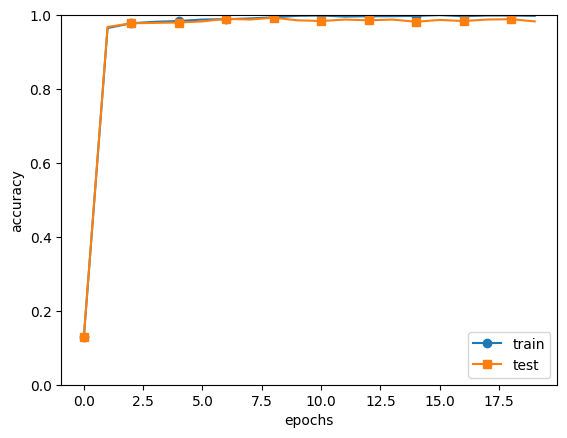

In [15]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
